# "Spinning" up custom kernels with Pallas
## Exploring Pallas in the context of the [Ising model](https://en.wikipedia.org/wiki/Ising_model)

This is a learning experiment where I'll try to implement an
efficient Metropolis-Hastings update of an $n$-dimensional Ising
model in Pallas.

## Summary
1. A straightforward `jit`ted JAX version with the CUDA backend is
   already quite fast! It beats the numpy benchmark by ~100x
   hand-coded CUDA implementation by ~3x (with the caveats that the
   latter is doing slightly more work, and does not make use of
   possible tiling optimizations using SRAM)
1. Current limitations of Pallas make it seem difficult or
   impossible to implement kernels that require overlapping or
   "haloed" tiles, at least using the high-level API:
   1. It seems like "element" indexing mode is necessary to describe
      overlapping blocks in `in_specs`, but this is currently
      unsupported on the GPU.
   1. The current restriction in the Triton backend that arrays must
      have sizes that are a power of 2 makes it awkward to express
      kernels that mix padded and unpadded tiles. E.g. for 16x16
      output tiles where the computation depends on nearest
      neighbors, we need to load 18x18 padded input tiles, but this
      is not possible with the current restriction.
  The Mosaic GPU backend may eventually address (b), but I ran into
  issues using it; it appears that it's not currently a drop-in
  replacement for Triton (e.g., errors running the quickstart
  examples: https://github.com/jax-ml/jax/issues/32123)

In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import time
from functools import partial, wraps

import jax
import jax.experimental.pallas as pl
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from numpy.typing import ArrayLike
from tqdm.auto import tqdm

from ising_mcmc.cuda.fm import sweeps as sweeps_cuda_impl

In [3]:
T_C = 2.269  # critical temperature of the 2-d Ising model
TEMPS_TC = np.array([0.9, 1.0, 1.1])  # temperatures to simulate, in units of T_c
TEMPS = T_C * TEMPS_TC
SIZE = 512  # lattice size

## Numpy reference implementation

The numpy reference below demonstrates the basic vectorized
algorithm. For each site in the lattice, we

1. compute the sum of the $2 d$ (4, in 2 dimensions) neighbor spins
1. from (1), compute the energy cost to flip the spin
1. accept or reject the flip with probability given by
   Metropolis-Hastings at the given temperature

The most straightforward implementation iterates sequentially over
all the spins in the lattice, performing the steps above.
Importantly, the state is updated after each iteration so that each
spin "sees" the updated value of its neighbors (this is required for
ergodicity).

The algorithm can be parallelized with a simple trick: we partition
the lattice into even and odd sites in a checkerboard pattern, and
sequentially update all the black squares (in parallel) and then all
the white squares. This ensures that every spin computes its update
based on the updated value of its neighbors.

In [4]:
def sweeps_numpy(spin: ArrayLike, temperature: ArrayLike, n_sweeps: int, seed: int):
    """
    Returns a copy of `spin` after n_sweeps Metropolis-Hastings
    updates of every site in the lattice.

    Parameters
    ----------
    spin : ArrayLike
      (n_temperatures, *lattice_dims) array of initial lattice spins
      batched by temperature

    temperature : ArrayLike
      (n_temperatures,) array of temperatures

    n_sweeps : int
      number of sweeps to perform

    seed : int
      PRNG seed

    Returns
    -------
    ndarray
      (n_temperatures, *lattice_dims) array of updated spins batched
      over temperature
    """
    spin = np.asarray(spin)
    temperature = np.asarray(temperature)

    n_temps = len(temperature)
    assert spin.shape[0] == n_temps
    lattice_shape = spin.shape[1:]

    mask = np.indices(lattice_shape).sum(0) % 2 == 0  # checkerboard mask

    rng = np.random.default_rng(seed)

    def sweep(spin):
        noise = rng.uniform(size=spin.shape)

        def sweep_masked(spin, mask):
            neighbor_sum = sum(
                np.roll(spin, offset, d)
                for d in range(1, spin.ndim)
                for offset in [-1, 1]
            )
            delta_energy = 2 * spin * neighbor_sum
            accepted = noise < np.exp(-delta_energy / temperature[:, None, None])
            return np.where(accepted & mask, -spin, spin)

        spin = sweep_masked(spin, mask)  # update even sites
        spin = sweep_masked(spin, ~mask)  # update odd sites

        return spin

    for _ in range(n_sweeps):
        spin = sweep(spin)

    return spin

We'll initialize the lattice with random spins (determined by a fair coin flip).

In [5]:
def random_spins(shape, seed):
    rng = np.random.default_rng(seed)
    s = rng.binomial(1, 0.5, shape).astype(np.int32)
    return 2 * s - 1

As a quick qualitative validation, we plot the final state of the
spin lattice after 1000 sweeps at the critical temperature and two
bracketing temperatures.

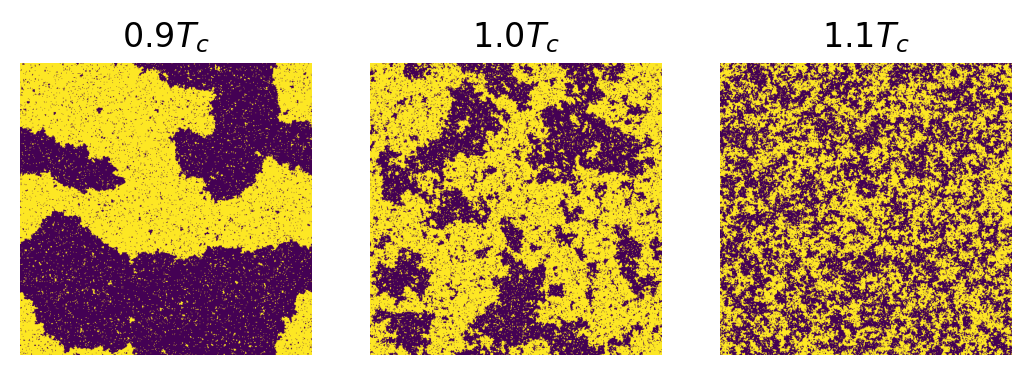

In [6]:
def make_plots(sweeps_fn, size=512, n_sweeps=1_000, init_seed=137, sweeps_seed=1337):
    _, axs = plt.subplots(1, len(TEMPS))
    spin_by_temp = random_spins((len(TEMPS), size, size), init_seed)
    spin_by_temp = sweeps_fn(spin_by_temp, TEMPS, n_sweeps, sweeps_seed)
    for ax, t, spin in zip(axs, TEMPS_TC, spin_by_temp):
        ax.imshow(spin)
        ax.set_axis_off()
        ax.set_title(rf"${t:.1f} T_c$")


make_plots(sweeps_numpy)

We'll use the following benchmark for a rough timing comparison of
various implementations. It runs the given function for a fixed
lattice size, number of sweeps, warmup iterations, and benchmarking
iterations; it then returns a result in nanoseconds per (spin)
update.

Note the use of `jax.block_until_ready`; this will be important to
ensure that we correctly benchmark async JAX code (relevant for
subsequent implementations).

In [7]:
def benchmark(sweeps_fn, size=512, n_sweeps=1_000, n_warmup=1, n_iters=3, seed=0):
    """Benchmarks the given implementation, returning a result in
    nanoseconds per spin update."""
    spin_by_temp = random_spins((len(TEMPS), size, size), seed)

    # Warmup iterations; avoid measuring initial compilation and cache warmup
    for _ in range(n_warmup):
        _ = jax.block_until_ready(sweeps_fn(spin_by_temp, TEMPS, n_sweeps, seed))

    # Benchmark iterations
    t0 = time.perf_counter()
    for _ in range(n_iters):
        _ = jax.block_until_ready(sweeps_fn(spin_by_temp, TEMPS, n_sweeps, seed))
    t1 = time.perf_counter()

    dt = t1 - t0
    return dt / n_iters / n_sweeps / size**2 * 1e9

In [8]:
numpy_timing = benchmark(sweeps_numpy)
numpy_timing

28.74164753722634

While the numpy version is a useful reference for the later parallel
implementations, on the CPU it's more efficient to do the updates in
place. For reference, we can compare the timing to a
lightly-optimized C version in the `ising_mcmc` package implemented
in this repo:

In [9]:
from ising_mcmc.cpu.fm import sweeps as sweeps_sequential_cpu_impl

# C version supports "external fields" (biases), but we'll ignore those here
H_EXT = np.zeros((len(TEMPS), SIZE, SIZE), np.float32)


def sweeps_sequential_cpu(spin, temperature, n_sweeps, seed):
    """Wrapper for C implementation of iterated MH updates (sweeps) of
    the Ising model."""
    spin, _, _, _ = sweeps_sequential_cpu_impl(spin, H_EXT, temperature, n_sweeps, seed)
    return spin

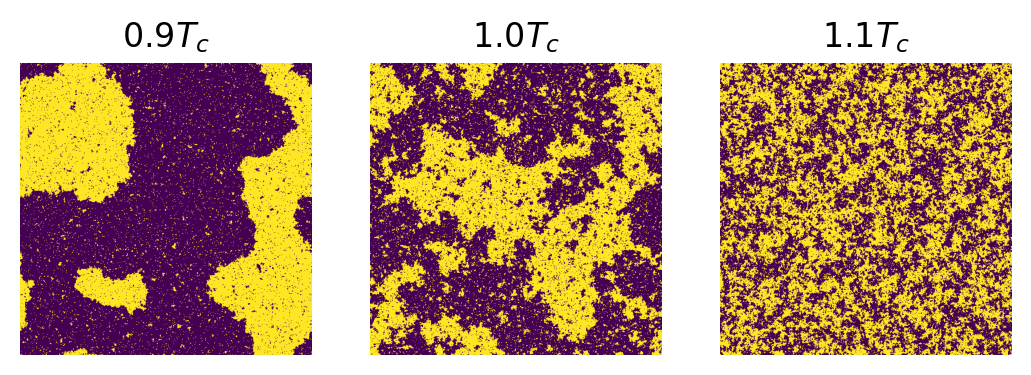

In [10]:
make_plots(sweeps_sequential_cpu)

In [11]:
sequential_cpu_timing = benchmark(sweeps_sequential_cpu)
sequential_cpu_timing, sequential_cpu_timing / numpy_timing

(25.242734166486258, 0.8782632983649157)

The numpy version is actually surprisingly close in performance to
the hand-coded C implementation. The latter is only lightly
optimized, so it's possible there's some room for improvement.

## CUDA implementation

A CUDA version is implemented in this repo in the package
`ising_mcmc`. It's a bit more general and does more than the toy
example we're concerned with here (e.g. also keeps track of the
number of accepted moves and the average sum of spins), but it
should give a reasonable estimate of how fast we should be able to
go on the GPU.

The CUDA implementation is [here](../src/ising_mcmc/cuda/fm_nd.cuh).
It's a pretty straightforward implementation that doesn't make use
of SRAM and tiling techniques, so there should be significant room
for improvement.

In [12]:
def sweeps_cuda(spin, temperature, n_sweeps, seed):
    spin, _, _, _ = sweeps_cuda_impl(spin, H_EXT, temperature, n_sweeps, seed)
    return spin

In [13]:
cuda_timing = benchmark(sweeps_cuda)
cuda_timing, cuda_timing / sequential_cpu_timing

(0.2905468647895759, 0.011510118629515302)

The CUDA version is roughly 100x faster (on an RTX 3090) than the
numpy and hand-coded C implementations.

## JAX baseline

How does the CUDA version compare to a plain JAX implementation (with JIT)?

The JAX implementation is mostly a mechanical translation of the
numpy reference; the only nontrivial difference is the replacement
of the "for" loop in the numpy version with `jax.lax.scan`, which
allows lowering of the loop by jit (rather than unrolling, which
would not be useful or feasible here).

One very nice property of the JAX implementation is that we can
simplify the implementation by making it agnostic to batch
dimensions (here, temperature), and automatically generate a batched
version equivalent to the explicitly-batched numpy version with
`vmap`:

In [14]:
def wrap_jax_impl(fn):
    """
    Utility to transform JAX/Pallas "sweeps" implementations to have
    an equivalent signature to the reference, i.e.

      (spin, temperature, n_sweeps, seed) -> spin

    with a leading batch dimension for the first two arguments.
    """
    fn = jax.vmap(fn)
    fn = jax.jit(fn)

    @wraps(fn)
    def wrapped(spin, temperature, n_sweeps, seed):
        keys = jax.random.split(jax.random.key(seed), (len(temperature), n_sweeps))
        return fn(keys, spin, temperature)

    return wrapped


@wrap_jax_impl
def sweeps_jax(keys, spin, temperature):
    mask = jnp.indices(spin.shape).sum(0) % 2 == 0  # checkerboard mask

    def sweep(key, spin):
        noise = jax.random.uniform(key, spin.shape)

        def sweep_masked(spin, mask):
            neighbor_sum = sum(
                jnp.roll(spin, offset, d)
                for d in range(spin.ndim)
                for offset in [-1, 1]
            )
            delta_energy = 2 * spin * neighbor_sum
            accepted = noise < jnp.exp(-delta_energy / temperature)
            return jnp.where(accepted & mask, -spin, spin)

        spin = sweep_masked(spin, mask)
        spin = sweep_masked(spin, ~mask)

        return spin

    spin, _ = jax.lax.scan(lambda spin, key: (sweep(key, spin), None), spin, keys)
    return spin

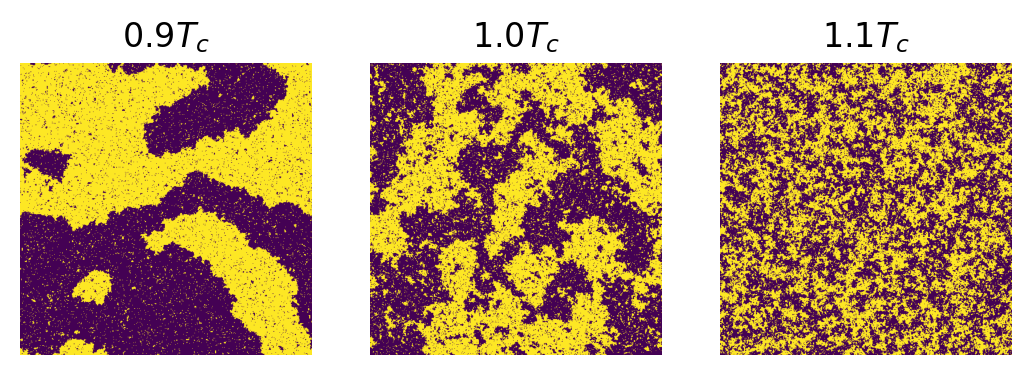

In [15]:
make_plots(sweeps_jax)

In [16]:
jax_timing = benchmark(sweeps_jax)
jax_timing, jax_timing / cuda_timing

(0.10105254618271904, 0.34780119295351813)

Wow, an impressive result from JAX without any custom kernel code!
It's already 3x faster than the hand-coded CUDA implementation. This
isn't necessarily surprising because the CUDA version is doing a
little more work (e.g. reduction for acceptance count) and is not
using any SRAM optimizations.

## Naive Pallas implementation

To get off the ground, let's start with the simplest possible Pallas
implementation that could possibly work---i.e. make the grid shape
equal to the shape of the spin lattice. This means that each
program_id corresponds with only a single spin, so there's no
vectorization at all happening on the warp level. This is extremely
wasteful, so we shouldn't expect much performance-wise.

In [17]:
def shift(idx, offset, axis):
    """Shift an n-dimensional index by the given offset along the given axis."""
    return tuple(x + offset if d == axis else x for d, x in enumerate(idx))


@wrap_jax_impl
def sweeps_pallas_naive(keys, spin, temperature):
    def sweep(key, spin):
        noise = jax.random.uniform(key, spin.shape)

        def sweep_masked(spin, parity):
            def kernel(
                parity, padded_spin_ref, noise_ref, temperature_ref, spin_out_ref
            ):
                ndim = padded_spin_ref.ndim
                idx = tuple(pl.program_id(d) for d in range(ndim))
                padded_idx = tuple(x + 1 for x in idx)
                curr_spin = padded_spin_ref[padded_idx]

                def update():
                    neighbor_sum = sum(
                        padded_spin_ref[shift(padded_idx, offset, d)]
                        for d in range(ndim)
                        for offset in [-1, 1]
                    )
                    delta_energy = 2 * curr_spin * neighbor_sum
                    temperature = temperature_ref[...]
                    accepted = noise_ref[idx] < jnp.exp(-delta_energy / temperature)
                    return jnp.where(accepted, -curr_spin, curr_spin)

                spin_out_ref[idx] = jax.lax.cond(
                    sum(idx) % 2 == parity,  # checkerboard mask
                    update,
                    lambda: curr_spin,
                )

            # Handle periodic boundary conditions with padding
            padded_spin = jnp.pad(spin, 1, "wrap")

            return pl.pallas_call(
                partial(kernel, parity),
                grid=spin.shape,  # XXX inefficient! (one program per lattice site)
                out_shape=jax.ShapeDtypeStruct((spin.shape), jnp.int32),
            )(padded_spin, noise, temperature)

        spin = sweep_masked(spin, 0)
        spin = sweep_masked(spin, 1)

        return spin

    spin, _ = jax.lax.scan(lambda spin, key: (sweep(key, spin), None), spin, keys)
    return spin

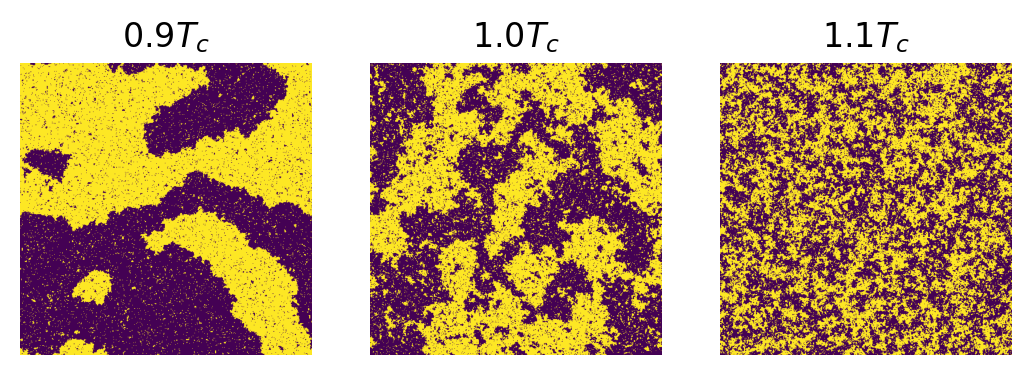

In [18]:
make_plots(sweeps_pallas_naive)

In [19]:
benchmark(sweeps_pallas_naive) / jax_timing

39.38523892995676

As expected, this is quite slow---the JAX baseline is almost 40
times faster! But we should see a big improvement by vectorizing at
the program level, giving those extra warp threads something to do.

One of the things we'll need for the vectorized version is a
checkerboard pattern that can be generated (or loaded) in the
kernel. A natural implementation might be something like

```python
checkerboard = jnp.indices(spin.shape).sum(0) % 2
```

but `jnp.indices` cannot currently be lowered to GPU code (at least
with the Triton backend, I was unable to get the Mosaic GPU backend
working), due to concatenation over an axis that is [not the
last](https://docs.jax.dev/en/latest/pallas/pipelining.html#reductions-and-accumulation):

In [20]:
def indices_broken(shape):
    def kernel(o_ref):
        o_ref[...] = jnp.indices(shape)

    return pl.pallas_call(
        kernel, out_shape=jax.ShapeDtypeStruct((len(shape), *shape), jnp.int32)
    )()


# Fails with: NotImplementedError: Only concatenate along the last
# dimension is supported.

# indices_broken((3, 3))

Fortunately, for our purposes the following implementation will work:

In [21]:
def checkerboard(shape):
    idxsum = jnp.zeros((), jnp.int32)
    for x in shape:
        idxsum = jnp.expand_dims(idxsum, -1) + jnp.arange(x)
    return idxsum % 2


def run_checkerboard_kernel(shape):
    def checkerboard_kernel(shape, o_ref):
        o_ref[...] = checkerboard(shape)

    return pl.pallas_call(
        partial(checkerboard_kernel, shape),
        out_shape=jax.ShapeDtypeStruct(shape, jnp.int32),
    )()


run_checkerboard_kernel((4, 4))

Array([[0, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 1, 0, 1],
       [1, 0, 1, 0]], dtype=int32)

## Vectorized Pallas implementation

In theory, the vectorized implementation should be pretty simple;
e.g. an initial plan could be to

1. Start with the JAX baseline version above
1. Adapt the kernel to work on a tile, rather than the full lattice;
   e.g. in the kernel we
   1. load the tile into SRAM with a "halo"; e.g. for a tile size of
      16 we load an 18x18 array of spins, ensuring that all
      neighbors are present
   1. don't wrap indices; instead of `jnp.roll` we can take simple
      slices that extend outside the tile boundary by one unit
1. Pad the initial spin array to implement periodic boundaries as we
   did in the previous example.

Unfortunately I ran into some "sharp edges" while trying to carry out the above plan:

1. The Triton backend requires that all arrays have power-of-2
   sizes. This seemingly makes it very difficult to work with
   unpadded and padded tiles in the kernel as we require.
2. Pallas' API for automatic pipelining, i.e. chunking up the inputs
   according to the `in_specs` and `out_specs` arguments to
   `pallas_call`, seems to have limited flexibility around working
   with overlapping tiles as we would like here. It looks like the
   ["element" indexing
   mode](https://docs.jax.dev/en/latest/pallas/grid_blockspec.html#the-element-indexing-mode)
   might support what we want to do, but this is currently only
   available for TPUs.

I was able to work around these limitations in a pretty suboptimal
way by loading $2 d$ mostly-identical copies of the spin tile into
SRAM (one for each neighbor). This is pretty far from optimal, and
we're still not doing any pipelining, but let's see if we at least
get an improvement over the naive version:

In [22]:
def cdiv(a, b):
    return (a + b - 1) // b


@wrap_jax_impl
@partial(partial, tile_size=16)
def sweeps_pallas_vectorized(keys, spin, temperature, tile_size):
    for d, extent in enumerate(spin.shape):
        assert spin.shape[0] == extent, (
            f"require hypercubic lattices, but got extent {spin.shape[0]} "
            f"along axis 0 and extent {extent} along axis {d}"
        )

    grid_size = cdiv(spin.shape[0], tile_size)

    def sweep(key, spin):
        noise = jax.random.uniform(key, spin.shape)

        def sweep_masked(spin, parity):
            def kernel(
                parity, padded_spin_ref, noise_ref, temperature_ref, spin_out_ref
            ):
                ndim = padded_spin_ref.ndim

                def mkslice(d, offset):
                    return pl.ds(pl.program_id(d) * tile_size + offset, tile_size)

                tile = tuple(mkslice(d, 0) for d in range(ndim))
                padded_tile = tuple(mkslice(d, 1) for d in range(ndim))

                spin = padded_spin_ref[padded_tile]
                noise = noise_ref[tile]

                # TODO: inefficient; redundant load from HBM (2*d times)
                def get_tile_slice(offset, axis):
                    return (
                        *(mkslice(k, 1) for k in range(axis)),
                        mkslice(axis, 1 + offset),
                        *(mkslice(k, 1) for k in range(axis + 1, ndim)),
                    )

                neighbor_spins = (
                    padded_spin_ref[get_tile_slice(offset, axis)]
                    for axis in range(ndim)
                    for offset in [-1, 1]
                )

                delta_energy = 2 * spin * sum(neighbor_spins)
                temperature = temperature_ref[...]
                accepted = noise < jnp.exp(-delta_energy / temperature)
                site_parity = jnp.logical_xor(
                    sum(pl.program_id(d) * tile_size for d in range(ndim)) % 2,
                    checkerboard((tile_size,) * ndim),
                )
                mask = site_parity == parity
                spin_out_ref[tile] = jnp.where(accepted & mask, -spin, spin)

            padded_spin = jnp.pad(spin, 1, "wrap")

            return pl.pallas_call(
                partial(kernel, parity),
                grid=(grid_size,) * spin.ndim,
                out_shape=jax.ShapeDtypeStruct((spin.shape), jnp.int32),
            )(padded_spin, noise, temperature)

        spin = sweep_masked(spin, 0)
        spin = sweep_masked(spin, 1)

        return spin

    spin, _ = jax.lax.scan(lambda spin, key: (sweep(key, spin), None), spin, keys)
    return spin

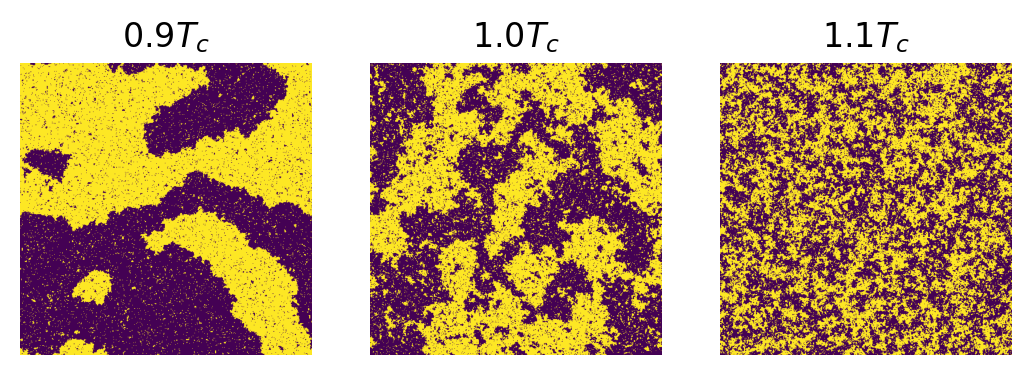

In [23]:
make_plots(sweeps_pallas_vectorized)

In [24]:
benchmark(sweeps_pallas_vectorized) / jax_timing

1.8705287499508862

Not bad, actually. This is already 50% faster than our CUDA version,
and almost half as fast as the JIT version. The latter is presumably
doing some intelligent pipelining, so it's not too surprising that
our specialized kernel is still behind.

For reference, below is the version I was hoping to be able to write
initially before running into the limitation around array dimensions
needing to be powers of 2:

In [25]:
@wrap_jax_impl
@partial(partial, tile_size=16)
def sweeps_vectorized_improved(keys, spin, temperature, tile_size):
    for d, extent in enumerate(spin.shape):
        assert spin.shape[0] == extent, (
            f"require hypercubic lattices, but got extent {spin.shape[0]} "
            f"along axis 0 and extent {extent} along axis {d}"
        )

    grid_size = cdiv(spin.shape[0], tile_size)

    def sweep(key, spin):
        noise = jax.random.uniform(key, spin.shape)

        def sweep_masked(spin, parity):
            def kernel(
                parity, padded_spin_ref, noise_ref, temperature_ref, spin_out_ref
            ):
                ndim = padded_spin_ref.ndim

                # Load tile with halo, shifted by 1 in each dimension
                # to account for padding
                shifted_tile_with_halo = tuple(
                    pl.ds(pl.program_id(d) * tile_size, tile_size + 2)
                    for d in range(ndim)
                )

                spin_with_halo = padded_spin_ref[shifted_tile_with_halo]

                tile = tuple(
                    pl.ds(pl.program_id(d) * tile_size, tile_size) for d in range(ndim)
                )

                noise = noise_ref[tile]

                def neighbor_spin(d, offset):
                    return spin_with_halo[
                        (slice(1, -1),) * d
                        + (slice(1 + offset, 1 + offset + tile_size),)
                        + (slice(1, -1),) * (ndim - d - 1)
                    ]

                neighbor_sum = sum(
                    neighbor_spin(d, offset) for d in range(ndim) for offset in [-1, 1]
                )

                spin = spin_with_halo[(slice(1, -1),) * ndim]

                delta_energy = 2 * spin * neighbor_sum
                temperature = temperature_ref[...]
                accepted = noise < jnp.exp(-delta_energy / temperature)
                site_parity = jnp.logical_xor(
                    sum(pl.program_id(d) * tile_size for d in range(ndim)) % 2,
                    checkerboard((tile_size,) * ndim),
                )
                mask = site_parity == parity
                spin_out_ref[tile] = jnp.where(accepted & mask, -spin, spin)

            padded_spin = jnp.pad(spin, 1, "wrap")

            return pl.pallas_call(
                partial(kernel, parity),
                grid=(grid_size,) * spin.ndim,
                out_shape=jax.ShapeDtypeStruct((spin.shape), jnp.int32),
            )(padded_spin, noise, temperature)

        spin = sweep_masked(spin, 0)
        spin = sweep_masked(spin, 1)

        return spin

    spin, _ = jax.lax.scan(lambda spin, key: (sweep(key, spin), None), spin, keys)
    return spin

In [26]:
# Fails with: ValueError: The Pallas Triton lowering currently
# requires that all operations have array arguments and results whose
# size is a power of 2. Encountered an array of shape (18, 18)

# make_plots(sweeps_vectorized_improved)

In [27]:
# benchmark(sweeps_vectorized_improved)

Next, I wanted to see if I could get a boost from Pallas' automatic
pipelining. Initally I was discouraged that the `BlockSpec` API
didn't seem to support overlapping tiles on GPUs, but then realized
this probably wouldn't be feasible anyway due to the Triton
backend's limitation around power-of-2 array sizes.

To make progress, I made peace with the idea of loading $2 d$
mostly-redundant spin tiles into SRAM, and also duplicating the
whole spin array $2 d$ times in HBM. The latter copy must be done
before every custom kernel invocation and seems likely to be a
significant bottleneck, so I'm not expecting great performance from
this version; however, it'll give us a testing ground for Pallas'
pipelining feature.

In [28]:
@wrap_jax_impl
@partial(partial, tile_size=16)
def sweeps_pallas_pipelined(keys, spin, temperature, tile_size):
    for d, extent in enumerate(spin.shape):
        assert spin.shape[0] == extent, (
            f"require hypercubic lattices, but got extent {spin.shape[0]} "
            f"along axis 0 and extent {extent} along axis {d}"
        )

    ndim = spin.ndim
    grid_size = cdiv(spin.shape[0], tile_size)
    tile_shape = (tile_size,) * ndim

    def sweep(key, spin):
        noise = jax.random.uniform(key, spin.shape)

        def sweep_masked(spin, parity):
            def kernel(
                parity,
                spin_ref,
                neighbor_refs,
                noise_ref,
                temperature_ref,
                spin_out_ref,
            ):
                spin = spin_ref[...]
                neighbor_spins = [ref[...] for ref in neighbor_refs]
                noise = noise_ref[...]
                temperature = temperature_ref[...]

                delta_energy = 2 * spin * sum(neighbor_spins)
                accepted = noise < jnp.exp(-delta_energy / temperature)
                site_parity = jnp.logical_xor(
                    sum(pl.program_id(d) * tile_size for d in range(ndim)) % 2,
                    checkerboard(tile_shape),
                )
                mask = site_parity == parity
                spin_out_ref[...] = jnp.where(accepted & mask, -spin, spin)

            # XXX inefficient! Makes 2*d copies of the entire spin
            # array before every sweep
            neighbor_spins = [
                jnp.roll(spin, offset, axis=d)
                for d in range(ndim)
                for offset in [-1, 1]
            ]

            block_spec = pl.BlockSpec(tile_shape, lambda *idx: idx)

            # With `neighbor_spins` precomputed, the specification of
            # the pipelined kernel call is relatively pleasant
            return pl.pallas_call(
                partial(kernel, parity),
                grid=(grid_size,) * ndim,
                out_shape=jax.ShapeDtypeStruct((spin.shape), jnp.int32),
                in_specs=[
                    block_spec,
                    [block_spec for _ in neighbor_spins],
                    block_spec,
                    pl.BlockSpec(()),
                ],
                out_specs=block_spec,
            )(spin, neighbor_spins, noise, temperature)

        spin = sweep_masked(spin, 0)
        spin = sweep_masked(spin, 1)

        return spin

    spin, _ = jax.lax.scan(lambda spin, key: (sweep(key, spin), None), spin, keys)
    return spin

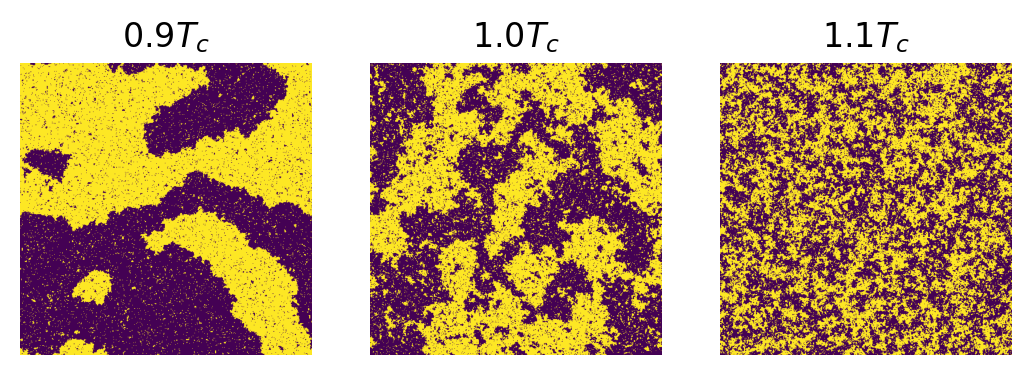

In [29]:
make_plots(sweeps_pallas_pipelined, size=512)

In [30]:
benchmark(sweeps_pallas_pipelined) / jax_timing

5.02977455013666

As expected, not great---the JAX baseline is about 5x faster.

I think the main issue with this approach is the overhead of making
4 copies of the spin array in HBM before every custom kernel launch.
It seems like we could work around this fairly straightforwardly if
it weren't for the Triton backend's restriction around power-of-2
array sizes, and we even might be able to make use of Pallas'
support for pipelining if "element" indexing mode were supported on
the GPU.

TODO: confirm this hypothesis via tracing

In [31]:
# Run the following to generate a gzipped json trace for inspection
# (can be viewed e.g. in chrome://tracing or perfetto)

# with jax.profiler.trace("logs"):
#     benchmark(sweeps_pallas_pipelined)

## Conclusions

See [Summary](lab#Summary)

## Benchmark summary

In [32]:
results = {
    sweeps_fn.__name__: benchmark(sweeps_fn)
    for sweeps_fn in tqdm(
        [
            sweeps_numpy,
            sweeps_sequential_cpu,
            sweeps_cuda,
            sweeps_jax,
            sweeps_pallas_naive,
            sweeps_pallas_vectorized,
            sweeps_pallas_pipelined,
            # sweeps_pipelined_overlapping,
        ]
    )
}

(
    pd.Series(results, name="ns_per_sweep")
    .to_frame()
    .assign(relative_timing=lambda df: df["ns_per_sweep"] / df["ns_per_sweep"].min())
    .sort_values("relative_timing")
)

  0%|          | 0/7 [00:00<?, ?it/s]

ns_per_sweep  relative_timing
sweeps_jax                    0.102727         1.000000
sweeps_pallas_vectorized      0.185123         1.802098
sweeps_cuda                   0.294457         2.866414
sweeps_pallas_pipelined       0.500956         4.876598
sweeps_pallas_naive           3.940059        38.354836
sweeps_sequential_cpu        25.243177       245.731841
sweeps_numpy                 28.623277       278.635711

# Appendix

## Version with overlapping tiles

As a starting point for future investigation, here's my initial
attempt at implementing an approach with overlapping tiles using
"element" indexing mode (untested, since currently unsupported on
GPU per the docs)

In [33]:
@wrap_jax_impl
@partial(partial, tile_size=16)
def sweeps_pipelined_overlapping(keys, spin, temperature, tile_size):
    for d, extent in enumerate(spin.shape):
        assert spin.shape[0] == extent, (
            f"require hypercubic lattices, but got extent {spin.shape[0]} "
            f"along axis 0 and extent {extent} along axis {d}"
        )

    ndim = spin.ndim
    grid_size = cdiv(spin.shape[0] - tile_size + 1, tile_size - 1)  # overlapping tiles
    tile_shape = (tile_size,) * ndim

    def sweep(key, spin):
        noise = jax.random.uniform(key, spin.shape)

        def sweep_masked(spin, parity):
            def kernel(
                parity, padded_spin_ref, noise_ref, temperature_ref, spin_out_ref
            ):
                padded_spin = padded_spin_ref[...]
                noise = noise_ref[...]
                temperature = temperature_ref[...]

                spin = padded_spin[(slice(1, -1),) * ndim]

                neighbor_spins = [
                    padded_spin[
                        (slice(1, -1),) * d + (s,) + (slice(1, -1),) * (ndim - d - 1)
                    ]
                    for d in range(ndim)
                    for s in [slice(0, -2), slice(2, None)]
                ]

                delta_energy = 2 * spin * sum(neighbor_spins)
                accepted = noise < jnp.exp(-delta_energy / temperature)
                site_parity = jnp.logical_xor(
                    sum(pl.program_id(d) * tile_size for d in range(ndim)) % 2,
                    checkerboard(tile_shape),
                )
                mask = site_parity == parity
                spin_out_ref[...] = jnp.where(accepted & mask, -spin, spin)

            block_spec = pl.BlockSpec(tile_shape, lambda *idx: idx)

            return pl.pallas_call(
                partial(kernel, parity),
                grid=(grid_size,) * ndim,
                out_shape=jax.ShapeDtypeStruct((spin.shape), jnp.int32),
                in_specs=[
                    pl.BlockSpec(
                        (pl.Element(tile_size + 2),) * ndim,
                        lambda *idx: tuple(x * tile_size - 1 for x in idx),
                    ),
                    block_spec,
                    pl.BlockSpec(()),
                ],
                out_specs=block_spec,
            )(spin, noise, temperature)

        spin = sweep_masked(spin, 0)
        spin = sweep_masked(spin, 1)

        return spin

    spin, _ = jax.lax.scan(lambda spin, key: (sweep(key, spin), None), spin, keys)
    return spin

In [34]:
# Fails: ValueError: The Pallas Triton lowering currently requires
# that all operations have array arguments and results whose size is a
# power of 2. Encountered an array of shape (18, 18)
#
# make_plots(sweeps_pipelined_overlapping, size=512)

In [35]:
# benchmark(sweeps_pipelined_overlapping)